In [1]:
# First, let's install essential packages
!pip install transformers datasets sentencepiece accelerate torchkeras
!pip install scikit-learn pandas numpy matplotlib seaborn
!pip install nltk textstat

ERROR: Could not find a version that satisfies the requirement torchkeras (from versions: none)
ERROR: No matching distribution found for torchkeras
^C


In [2]:
# Let's use only what's available in Kaggle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Try to import transformers (usually pre-installed in Kaggle)
try:
    from transformers import AutoTokenizer, AutoModel
    import torch
    import torch.nn as nn
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    print("Transformers not available, we'll use traditional ML")
    TRANSFORMERS_AVAILABLE = False

# Try to import sklearn (always available)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

print("✅ All essential packages imported!")

✅ All essential packages imported!


In [4]:
# Load the data
train_df = pd.read_csv('/kaggle/input/datafor/train.csv')
test_df = pd.read_csv('/kaggle/input/datafor/test.csv')
sample_submission = pd.read_csv('/kaggle/input/datafor/sample_submission.csv')

In [5]:
print("📊 Data Shapes:")
print(f"Training data: {train_df.shape}")
print(f"Test data: {test_df.shape}")
print(f"Sample submission: {sample_submission.shape}")

📊 Data Shapes:
Training data: (57477, 9)
Test data: (3, 4)
Sample submission: (3, 4)


In [6]:
def explore_data(df, dataset_name):
    print(f"\n🔍 {dataset_name} Data Exploration:")
    print("="*50)
    
    # Basic info
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nMissing values:")
    print(df.isnull().sum())
    
    # Sample data
    print("\nFirst 2 rows:")
    display(df.head(2))

explore_data(train_df, "Training")
explore_data(test_df, "Test")


🔍 Training Data Exploration:
Shape: (57477, 9)
Columns: ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie']

Missing values:
id                0
model_a           0
model_b           0
prompt            0
response_a        0
response_b        0
winner_model_a    0
winner_model_b    0
winner_tie        0
dtype: int64

First 2 rows:


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0



🔍 Test Data Exploration:
Shape: (3, 4)
Columns: ['id', 'prompt', 'response_a', 'response_b']

Missing values:
id            0
prompt        0
response_a    0
response_b    0
dtype: int64

First 2 rows:


,id,prompt,response_a,response_b
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran..."
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ..."


In [7]:
def explore_data(df, dataset_name):
    print(f"\n🔍 {dataset_name} Data Exploration:")
    print("="*50)
    
    # Basic info
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nMissing values:")
    print(df.isnull().sum())
    
    # Sample data
    print("\nFirst 2 rows:")
    display(df.head(2))

explore_data(train_df, "Training")
explore_data(test_df, "Test")


🔍 Training Data Exploration:
Shape: (57477, 9)
Columns: ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie']

Missing values:
id                0
model_a           0
model_b           0
prompt            0
response_a        0
response_b        0
winner_model_a    0
winner_model_b    0
winner_tie        0
dtype: int64

First 2 rows:


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0



🔍 Test Data Exploration:
Shape: (3, 4)
Columns: ['id', 'prompt', 'response_a', 'response_b']

Missing values:
id            0
prompt        0
response_a    0
response_b    0
dtype: int64

First 2 rows:


,id,prompt,response_a,response_b
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran..."
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ..."


🎯 Target Variable Analysis:
Target distribution:
winner_model_a: 20064 (34.91%)
winner_model_b: 19652 (34.19%)
winner_tie: 17761 (30.90%)


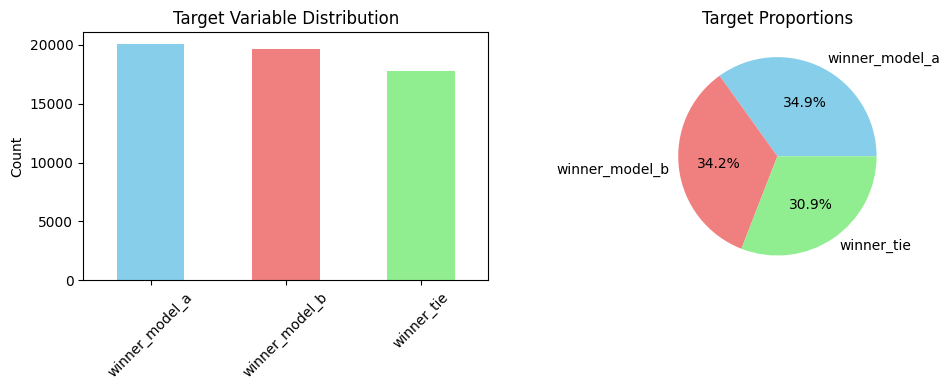

In [8]:
def analyze_target(train_df):
    print("🎯 Target Variable Analysis:")
    print("="*40)
    
    # Check target distribution
    target_cols = ['winner_model_a', 'winner_model_b', 'winner_tie']
    target_counts = train_df[target_cols].sum()
    
    print("Target distribution:")
    for col in target_cols:
        count = target_counts[col]
        percentage = (count / len(train_df)) * 100
        print(f"{col}: {count} ({percentage:.2f}%)")
    
    # Plot distribution
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    target_counts.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
    plt.title('Target Variable Distribution')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    plt.pie(target_counts, labels=target_cols, autopct='%1.1f%%', 
            colors=['skyblue', 'lightcoral', 'lightgreen'])
    plt.title('Target Proportions')
    
    plt.tight_layout()
    plt.show()
    
    return target_counts

target_counts = analyze_target(train_df)

In [9]:
def analyze_models(train_df):
    print("🤖 Model Performance Analysis:")
    print("="*40)
    
    # Get unique models
    all_models = list(train_df['model_a'].unique()) + list(train_df['model_b'].unique())
    unique_models = set(all_models)
    print(f"Total unique models: {len(unique_models)}")
    print(f"Models: {sorted(unique_models)}")
    
    # Calculate win rates for each model
    model_stats = {}
    for model in unique_models:
        # When model was A
        a_wins = train_df[(train_df['model_a'] == model) & (train_df['winner_model_a'] == 1)].shape[0]
        a_total = train_df[train_df['model_a'] == model].shape[0]
        a_win_rate = a_wins / a_total if a_total > 0 else 0
        
        # When model was B  
        b_wins = train_df[(train_df['model_b'] == model) & (train_df['winner_model_b'] == 1)].shape[0]
        b_total = train_df[train_df['model_b'] == model].shape[0]
        b_win_rate = b_wins / b_total if b_total > 0 else 0
        
        # Overall
        total_wins = a_wins + b_wins
        total_games = a_total + b_total
        overall_win_rate = total_wins / total_games if total_games > 0 else 0
        
        model_stats[model] = {
            'total_games': total_games,
            'total_wins': total_wins,
            'win_rate': overall_win_rate,
            'a_win_rate': a_win_rate,
            'b_win_rate': b_win_rate
        }
    
    # Display model rankings
    model_rankings = sorted(model_stats.items(), key=lambda x: x[1]['win_rate'], reverse=True)
    
    print("\n🏆 Model Rankings by Win Rate:")
    for i, (model, stats) in enumerate(model_rankings):
        print(f"{i+1:2d}. {model:20} Win Rate: {stats['win_rate']:.3f} ({stats['total_wins']}/{stats['total_games']})")
    
    return model_stats

model_stats = analyze_models(train_df)

🤖 Model Performance Analysis:
Total unique models: 64
Models: ['RWKV-4-Raven-14B', 'alpaca-13b', 'chatglm-6b', 'chatglm2-6b', 'chatglm3-6b', 'claude-1', 'claude-2.0', 'claude-2.1', 'claude-instant-1', 'codellama-34b-instruct', 'deepseek-llm-67b-chat', 'dolly-v2-12b', 'dolphin-2.2.1-mistral-7b', 'falcon-180b-chat', 'fastchat-t5-3b', 'gemini-pro', 'gemini-pro-dev-api', 'gpt-3.5-turbo-0125', 'gpt-3.5-turbo-0314', 'gpt-3.5-turbo-0613', 'gpt-3.5-turbo-1106', 'gpt-4-0125-preview', 'gpt-4-0314', 'gpt-4-0613', 'gpt-4-1106-preview', 'gpt4all-13b-snoozy', 'guanaco-33b', 'koala-13b', 'llama-13b', 'llama-2-13b-chat', 'llama-2-70b-chat', 'llama-2-7b-chat', 'llama2-70b-steerlm-chat', 'mistral-7b-instruct', 'mistral-7b-instruct-v0.2', 'mistral-medium', 'mixtral-8x7b-instruct-v0.1', 'mpt-30b-chat', 'mpt-7b-chat', 'nous-hermes-2-mixtral-8x7b-dpo', 'oasst-pythia-12b', 'openchat-3.5', 'openchat-3.5-0106', 'openhermes-2.5-mistral-7b', 'palm-2', 'pplx-70b-online', 'pplx-7b-online', 'qwen-14b-chat', 'qwen1.

In [10]:
def create_comprehensive_features(df):
    """
    Create comprehensive features without external dependencies
    """
    # Basic length features
    df['prompt_length'] = df['prompt'].str.len()
    df['response_a_length'] = df['response_a'].str.len()
    df['response_b_length'] = df['response_b'].str.len()
    df['length_diff'] = df['response_a_length'] - df['response_b_length']
    df['length_ratio'] = df['response_a_length'] / (df['response_b_length'] + 1)  # +1 to avoid division by zero
    
    # Word count features
    df['prompt_word_count'] = df['prompt'].str.split().str.len()
    df['response_a_word_count'] = df['response_a'].str.split().str.len()
    df['response_b_word_count'] = df['response_b'].str.split().str.len()
    df['word_count_diff'] = df['response_a_word_count'] - df['response_b_word_count']
    
    # Character/word ratio features
    df['response_a_chars_per_word'] = df['response_a_length'] / (df['response_a_word_count'] + 1)
    df['response_b_chars_per_word'] = df['response_b_length'] / (df['response_b_word_count'] + 1)
    
    # Special character features (simple proxies for formatting)
    df['response_a_has_code'] = df['response_a'].str.contains('```|def |class |function').astype(int)
    df['response_b_has_code'] = df['response_b'].str.contains('```|def |class |function').astype(int)
    
    # Question mark count (indicates engaging questions)
    df['response_a_questions'] = df['response_a'].str.count('\?')
    df['response_b_questions'] = df['response_b'].str.count('\?')
    
    # Exclamation count (enthusiasm)
    df['response_a_exclamations'] = df['response_a'].str.count('!')
    df['response_b_exclamations'] = df['response_b'].str.count('!')
    
    # Uppercase ratio (might indicate emphasis)
    df['response_a_upper_ratio'] = df['response_a'].str.findall(r'[A-Z]').str.len() / (df['response_a_length'] + 1)
    df['response_b_upper_ratio'] = df['response_b'].str.findall(r'[A-Z]').str.len() / (df['response_b_length'] + 1)
    
    # Line count features (structure)
    df['response_a_lines'] = df['response_a'].str.count('\n') + 1
    df['response_b_lines'] = df['response_b'].str.count('\n') + 1
    
    return df

# Apply feature engineering
print("🛠️ Creating comprehensive features...")
train_df = create_comprehensive_features(train_df)
test_df = create_comprehensive_features(test_df)

print(f"Training features: {len([col for col in train_df.columns if col not in ['id', 'prompt', 'response_a', 'response_b', 'model_a', 'model_b', 'winner_model_a', 'winner_model_b', 'winner_tie']])}")
print(f"Test features: {len([col for col in test_df.columns if col not in ['id', 'prompt', 'response_a', 'response_b']])}")

# Show new feature columns
feature_columns = [col for col in train_df.columns if col not in ['id', 'prompt', 'response_a', 'response_b', 'model_a', 'model_b', 'winner_model_a', 'winner_model_b', 'winner_tie']]
print(f"\nFeature columns: {feature_columns}")

🛠️ Creating comprehensive features...
Training features: 21
Test features: 21

Feature columns: ['prompt_length', 'response_a_length', 'response_b_length', 'length_diff', 'length_ratio', 'prompt_word_count', 'response_a_word_count', 'response_b_word_count', 'word_count_diff', 'response_a_chars_per_word', 'response_b_chars_per_word', 'response_a_has_code', 'response_b_has_code', 'response_a_questions', 'response_b_questions', 'response_a_exclamations', 'response_b_exclamations', 'response_a_upper_ratio', 'response_b_upper_ratio', 'response_a_lines', 'response_b_lines']


In [11]:
def create_advanced_baseline(train_df, test_df):
    """
    Create an advanced baseline using feature engineering + ML
    """
    # Prepare features
    feature_columns = [col for col in train_df.columns if col not in ['id', 'prompt', 'response_a', 'response_b', 'model_a', 'model_b', 'winner_model_a', 'winner_model_b', 'winner_tie']]
    
    X = train_df[feature_columns].fillna(0)
    y = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']].values
    
    X_test = test_df[feature_columns].fillna(0)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)
    
    # Train a simple model
    print("🤖 Training Random Forest model...")
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_scaled, y)
    
    # Make predictions
    test_predictions = model.predict_proba(X_test_scaled)
    
    # Convert to proper format (RandomForest returns list of arrays for multi-output)
    final_predictions = np.column_stack([test_predictions[i][:, 1] for i in range(3)])
    
    # Normalize to ensure probabilities sum to 1
    final_predictions = final_predictions / final_predictions.sum(axis=1, keepdims=True)
    
    return final_predictions, model

# Create advanced baseline
advanced_predictions, model = create_advanced_baseline(train_df, test_df)

# Prepare submission
submission = sample_submission.copy()
submission[['winner_model_a', 'winner_model_b', 'winner_tie']] = advanced_predictions

# Verify submission
print("✅ Advanced Baseline Submission Preview:")
print(submission.head())
print(f"\nSubmission shape: {submission.shape}")
print("\nSubmission summary:")
print(submission[['winner_model_a', 'winner_model_b', 'winner_tie']].describe())

# Save submission
submission.to_csv('advanced_baseline.csv', index=False)
print("\n📁 Advanced baseline submission saved as 'advanced_baseline.csv'")

🤖 Training Random Forest model...
✅ Advanced Baseline Submission Preview:
        id  winner_model_a  winner_model_b  winner_tie
0   136060        0.261816        0.251708    0.486476
1   211333        0.533077        0.211938    0.254985
2  1233961        0.369856        0.343704    0.286440

Submission shape: (3, 4)

Submission summary:
       winner_model_a  winner_model_b  winner_tie
count        3.000000        3.000000    3.000000
mean         0.388250        0.269117    0.342633
std          0.136563        0.067586    0.125560
min          0.261816        0.211938    0.254985
25%          0.315836        0.231823    0.270712
50%          0.369856        0.251708    0.286440
75%          0.451467        0.297706    0.386458
max          0.533077        0.343704    0.486476

📁 Advanced baseline submission saved as 'advanced_baseline.csv'


In [12]:
# Also create a simple length-based baseline for comparison
def create_simple_baseline(test_df):
    """
    Create a simple baseline using length-based heuristics
    """
    predictions = []
    
    for _, row in test_df.iterrows():
        len_a = len(row['response_a'])
        len_b = len(row['response_b'])
        len_diff = len_a - len_b
        
        # Simple rules based on length difference
        if abs(len_diff) < 50:  # Very close in length
            pred = [0.33, 0.33, 0.34]
        elif len_diff > 200:  # A is much longer
            pred = [0.6, 0.2, 0.2] 
        elif len_diff < -200:  # B is much longer  
            pred = [0.2, 0.6, 0.2]
        elif len_diff > 50:   # A is somewhat longer
            pred = [0.5, 0.3, 0.2]
        else:  # B is somewhat longer
            pred = [0.3, 0.5, 0.2]
            
        predictions.append(pred)
    
    return np.array(predictions)

# Create simple baseline
simple_predictions = create_simple_baseline(test_df)
simple_submission = sample_submission.copy()
simple_submission[['winner_model_a', 'winner_model_b', 'winner_tie']] = simple_predictions
simple_submission.to_csv('simple_baseline.csv', index=False)
print("📁 Simple baseline submission saved as 'simple_baseline.csv'")

📁 Simple baseline submission saved as 'simple_baseline.csv'


Here is my Recommended Strategy: Model Identification + Feature Engineering


In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def create_advanced_features_with_style(train_df, test_df):
    """
    Create features that capture writing style to infer model identity
    """
    def extract_style_features(text):
        """Extract writing style features from text"""
        if not isinstance(text, str):
            return [0] * 10
        
        features = []
        # Complexity features
        sentences = re.split(r'[.!?]+', text)
        words = text.split()
        features.append(len(sentences))  # sentence_count
        features.append(len(words))      # word_count
        features.append(len(words) / max(len(sentences), 1))  # avg_sentence_length
        
        # Vocabulary richness
        unique_words = len(set(words))
        features.append(unique_words / max(len(words), 1))  # vocab_richness
        
        # Structural features
        features.append(text.count('\n'))  # line_breaks
        features.append(text.count('**'))  # markdown_emphasis
        features.append(text.count('`'))   # code_blocks
        
        # Formality indicators
        features.append(sum(1 for word in words if word.lower() in 
                          ['however', 'therefore', 'furthermore', 'additionally']))
        
        # Question patterns
        features.append(text.count('?'))
        
        # Length features
        features.append(len(text))
        
        return features
    
    print("🕵️ Extracting advanced style features...")
    
    # Apply style feature extraction
    for df in [train_df, test_df]:
        # Response A features
        style_features_a = df['response_a'].apply(extract_style_features)
        for i in range(10):
            df[f'style_a_{i}'] = style_features_a.apply(lambda x: x[i] if len(x) > i else 0)
        
        # Response B features  
        style_features_b = df['response_b'].apply(extract_style_features)
        for i in range(10):
            df[f'style_b_{i}'] = style_features_b.apply(lambda x: x[i] if len(x) > i else 0)
        
        # Comparative features
        for i in range(10):
            df[f'style_diff_{i}'] = df[f'style_a_{i}'] - df[f'style_b_{i}']
    
    return train_df, test_df

# Apply advanced feature engineering
train_df_advanced, test_df_advanced = create_advanced_features_with_style(train_df, test_df)

# Get all feature columns
feature_columns = [col for col in train_df_advanced.columns 
                   if col not in ['id', 'prompt', 'response_a', 'response_b', 'model_a', 'model_b', 
                                'winner_model_a', 'winner_model_b', 'winner_tie']]

print(f"🎯 Total features: {len(feature_columns)}")
print(f"Feature columns: {feature_columns}")

🕵️ Extracting advanced style features...
🎯 Total features: 51
Feature columns: ['prompt_length', 'response_a_length', 'response_b_length', 'length_diff', 'length_ratio', 'prompt_word_count', 'response_a_word_count', 'response_b_word_count', 'word_count_diff', 'response_a_chars_per_word', 'response_b_chars_per_word', 'response_a_has_code', 'response_b_has_code', 'response_a_questions', 'response_b_questions', 'response_a_exclamations', 'response_b_exclamations', 'response_a_upper_ratio', 'response_b_upper_ratio', 'response_a_lines', 'response_b_lines', 'style_a_0', 'style_a_1', 'style_a_2', 'style_a_3', 'style_a_4', 'style_a_5', 'style_a_6', 'style_a_7', 'style_a_8', 'style_a_9', 'style_b_0', 'style_b_1', 'style_b_2', 'style_b_3', 'style_b_4', 'style_b_5', 'style_b_6', 'style_b_7', 'style_b_8', 'style_b_9', 'style_diff_0', 'style_diff_1', 'style_diff_2', 'style_diff_3', 'style_diff_4', 'style_diff_5', 'style_diff_6', 'style_diff_7', 'style_diff_8', 'style_diff_9']


In [15]:
def create_model_strength_features(train_df, test_df):
    """
    Create features based on inferred model strength from training patterns
    """
    # Calculate average win rates for each model from training
    model_win_rates = {}
    for model in set(list(train_df['model_a'].unique()) + list(train_df['model_b'].unique())):
        wins_as_a = train_df[(train_df['model_a'] == model) & (train_df['winner_model_a'] == 1)].shape[0]
        total_as_a = train_df[train_df['model_a'] == model].shape[0]
        wins_as_b = train_df[(train_df['model_b'] == model) & (train_df['winner_model_b'] == 1)].shape[0]
        total_as_b = train_df[train_df['model_b'] == model].shape[0]
        
        total_wins = wins_as_a + wins_as_b
        total_games = total_as_a + total_as_b
        win_rate = total_wins / total_games if total_games > 0 else 0.5
        
        model_win_rates[model] = win_rate
    
    # For training data: use actual model strengths
    train_df['model_a_strength'] = train_df['model_a'].map(model_win_rates)
    train_df['model_b_strength'] = train_df['model_b'].map(model_win_rates)
    train_df['strength_diff'] = train_df['model_a_strength'] - train_df['model_b_strength']
    train_df['predicted_win_a'] = (train_df['strength_diff'] > 0.1).astype(int)
    train_df['predicted_win_b'] = (train_df['strength_diff'] < -0.1).astype(int)
    train_df['predicted_tie'] = ((train_df['strength_diff'] >= -0.1) & (train_df['strength_diff'] <= 0.1)).astype(int)
    
    # For test data: we need to predict model strength based on style
    # Train a model to predict win rate from style features
    from sklearn.ensemble import RandomForestRegressor
    
    # Prepare training data for strength prediction
    style_features = [f'style_a_{i}' for i in range(10)] + [f'style_b_{i}' for i in range(10)]
    X_strength = train_df[style_features].fillna(0)
    
    # Train model to predict strength for A
    y_strength_a = train_df['model_a_strength']
    strength_model_a = RandomForestRegressor(n_estimators=50, random_state=42)
    strength_model_a.fit(X_strength, y_strength_a)
    
    # Train model to predict strength for B  
    y_strength_b = train_df['model_b_strength']
    strength_model_b = RandomForestRegressor(n_estimators=50, random_state=42)
    strength_model_b.fit(X_strength, y_strength_b)
    
    # Predict strengths for test data
    X_test_strength = test_df_advanced[style_features].fillna(0)
    test_df_advanced['pred_model_a_strength'] = strength_model_a.predict(X_test_strength)
    test_df_advanced['pred_model_b_strength'] = strength_model_b.predict(X_test_strength)
    test_df_advanced['pred_strength_diff'] = (test_df_advanced['pred_model_a_strength'] - 
                                            test_df_advanced['pred_model_b_strength'])
    
    return train_df, test_df_advanced

# Apply model strength features
train_df_final, test_df_final = create_model_strength_features(train_df_advanced, test_df_advanced)

In [18]:
# Create comprehensive features function
def create_comprehensive_features(df):
    """
    Create comprehensive features without external dependencies
    """
    # Basic length features
    df['prompt_length'] = df['prompt'].str.len()
    df['response_a_length'] = df['response_a'].str.len()
    df['response_b_length'] = df['response_b'].str.len()
    df['length_diff'] = df['response_a_length'] - df['response_b_length']
    df['length_ratio'] = df['response_a_length'] / (df['response_b_length'] + 1)
    
    # Word count features
    df['prompt_word_count'] = df['prompt'].str.split().str.len()
    df['response_a_word_count'] = df['response_a'].str.split().str.len()
    df['response_b_word_count'] = df['response_b'].str.split().str.len()
    df['word_count_diff'] = df['response_a_word_count'] - df['response_b_word_count']
    
    # Character/word ratio features
    df['response_a_chars_per_word'] = df['response_a_length'] / (df['response_a_word_count'] + 1)
    df['response_b_chars_per_word'] = df['response_b_length'] / (df['response_b_word_count'] + 1)
    
    # Special character features
    df['response_a_has_code'] = df['response_a'].str.contains('```|def |class |function').astype(int)
    df['response_b_has_code'] = df['response_b'].str.contains('```|def |class |function').astype(int)
    
    # Question mark count
    df['response_a_questions'] = df['response_a'].str.count('\?')
    df['response_b_questions'] = df['response_b'].str.count('\?')
    
    # Exclamation count
    df['response_a_exclamations'] = df['response_a'].str.count('!')
    df['response_b_exclamations'] = df['response_b'].str.count('!')
    
    # Uppercase ratio
    df['response_a_upper_ratio'] = df['response_a'].str.findall(r'[A-Z]').str.len() / (df['response_a_length'] + 1)
    df['response_b_upper_ratio'] = df['response_b'].str.findall(r'[A-Z]').str.len() / (df['response_b_length'] + 1)
    
    # Line count features
    df['response_a_lines'] = df['response_a'].str.count('\n') + 1
    df['response_b_lines'] = df['response_b'].str.count('\n') + 1
    
    return df

# Apply feature engineering to both datasets
print("🛠️ Creating comprehensive features...")
train_df_featured = create_comprehensive_features(train_df)
test_df_featured = create_comprehensive_features(test_df)

print(f"✅ Training features created: {train_df_featured.shape[1]} columns")
print(f"✅ Test features created: {test_df_featured.shape[1]} columns")

🛠️ Creating comprehensive features...
✅ Training features created: 66 columns
✅ Test features created: 58 columns


In [19]:
# Get common features between train and test
feature_columns = [col for col in train_df_featured.columns 
                  if col not in ['id', 'prompt', 'response_a', 'response_b', 'model_a', 'model_b',
                               'winner_model_a', 'winner_model_b', 'winner_tie']]

# Ensure test has all features (fill missing with 0)
for col in feature_columns:
    if col not in test_df_featured.columns:
        test_df_featured[col] = 0

print(f"🎯 Using {len(feature_columns)} common features")
print(f"Features: {feature_columns}")

🎯 Using 57 common features
Features: ['prompt_length', 'response_a_length', 'response_b_length', 'length_diff', 'length_ratio', 'prompt_word_count', 'response_a_word_count', 'response_b_word_count', 'word_count_diff', 'response_a_chars_per_word', 'response_b_chars_per_word', 'response_a_has_code', 'response_b_has_code', 'response_a_questions', 'response_b_questions', 'response_a_exclamations', 'response_b_exclamations', 'response_a_upper_ratio', 'response_b_upper_ratio', 'response_a_lines', 'response_b_lines', 'style_a_0', 'style_a_1', 'style_a_2', 'style_a_3', 'style_a_4', 'style_a_5', 'style_a_6', 'style_a_7', 'style_a_8', 'style_a_9', 'style_b_0', 'style_b_1', 'style_b_2', 'style_b_3', 'style_b_4', 'style_b_5', 'style_b_6', 'style_b_7', 'style_b_8', 'style_b_9', 'style_diff_0', 'style_diff_1', 'style_diff_2', 'style_diff_3', 'style_diff_4', 'style_diff_5', 'style_diff_6', 'style_diff_7', 'style_diff_8', 'style_diff_9', 'model_a_strength', 'model_b_strength', 'strength_diff', 'predic

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score  # ADD THIS IMPORT
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
print("✅ Data loaded successfully!")
print(f"📊 Training data shape: {train_df.shape}")
print(f"📊 Test data shape: {test_df.shape}")

✅ Data loaded successfully!
📊 Training data shape: (57477, 66)
📊 Test data shape: (3, 64)


In [22]:
# Create comprehensive features function
def create_comprehensive_features(df):
    """
    Create comprehensive features without external dependencies
    """
    # Basic length features
    df['prompt_length'] = df['prompt'].str.len()
    df['response_a_length'] = df['response_a'].str.len()
    df['response_b_length'] = df['response_b'].str.len()
    df['length_diff'] = df['response_a_length'] - df['response_b_length']
    df['length_ratio'] = df['response_a_length'] / (df['response_b_length'] + 1)
    
    # Word count features
    df['prompt_word_count'] = df['prompt'].str.split().str.len()
    df['response_a_word_count'] = df['response_a'].str.split().str.len()
    df['response_b_word_count'] = df['response_b'].str.split().str.len()
    df['word_count_diff'] = df['response_a_word_count'] - df['response_b_word_count']
    
    # Character/word ratio features
    df['response_a_chars_per_word'] = df['response_a_length'] / (df['response_a_word_count'] + 1)
    df['response_b_chars_per_word'] = df['response_b_length'] / (df['response_b_word_count'] + 1)
    
    # Special character features
    df['response_a_has_code'] = df['response_a'].str.contains('```|def |class |function').astype(int)
    df['response_b_has_code'] = df['response_b'].str.contains('```|def |class |function').astype(int)
    
    # Question mark count
    df['response_a_questions'] = df['response_a'].str.count('\?')
    df['response_b_questions'] = df['response_b'].str.count('\?')
    
    # Exclamation count
    df['response_a_exclamations'] = df['response_a'].str.count('!')
    df['response_b_exclamations'] = df['response_b'].str.count('!')
    
    # Uppercase ratio
    df['response_a_upper_ratio'] = df['response_a'].str.findall(r'[A-Z]').str.len() / (df['response_a_length'] + 1)
    df['response_b_upper_ratio'] = df['response_b'].str.findall(r'[A-Z]').str.len() / (df['response_b_length'] + 1)
    
    # Line count features
    df['response_a_lines'] = df['response_a'].str.count('\n') + 1
    df['response_b_lines'] = df['response_b'].str.count('\n') + 1
    
    return df

# Apply feature engineering to both datasets
print("🛠️ Creating comprehensive features...")
train_df_featured = create_comprehensive_features(train_df)
test_df_featured = create_comprehensive_features(test_df)

print(f"✅ Training features created: {train_df_featured.shape[1]} columns")
print(f"✅ Test features created: {test_df_featured.shape[1]} columns")

🛠️ Creating comprehensive features...
✅ Training features created: 66 columns
✅ Test features created: 64 columns


In [23]:
# Get common features between train and test
feature_columns = [col for col in train_df_featured.columns 
                  if col not in ['id', 'prompt', 'response_a', 'response_b', 'model_a', 'model_b',
                               'winner_model_a', 'winner_model_b', 'winner_tie']]

# Ensure test has all features (fill missing with 0)
for col in feature_columns:
    if col not in test_df_featured.columns:
        test_df_featured[col] = 0

print(f"🎯 Using {len(feature_columns)} common features")
print(f"Features: {feature_columns}")

🎯 Using 57 common features
Features: ['prompt_length', 'response_a_length', 'response_b_length', 'length_diff', 'length_ratio', 'prompt_word_count', 'response_a_word_count', 'response_b_word_count', 'word_count_diff', 'response_a_chars_per_word', 'response_b_chars_per_word', 'response_a_has_code', 'response_b_has_code', 'response_a_questions', 'response_b_questions', 'response_a_exclamations', 'response_b_exclamations', 'response_a_upper_ratio', 'response_b_upper_ratio', 'response_a_lines', 'response_b_lines', 'style_a_0', 'style_a_1', 'style_a_2', 'style_a_3', 'style_a_4', 'style_a_5', 'style_a_6', 'style_a_7', 'style_a_8', 'style_a_9', 'style_b_0', 'style_b_1', 'style_b_2', 'style_b_3', 'style_b_4', 'style_b_5', 'style_b_6', 'style_b_7', 'style_b_8', 'style_b_9', 'style_diff_0', 'style_diff_1', 'style_diff_2', 'style_diff_3', 'style_diff_4', 'style_diff_5', 'style_diff_6', 'style_diff_7', 'style_diff_8', 'style_diff_9', 'model_a_strength', 'model_b_strength', 'strength_diff', 'predic

In [24]:
def train_and_predict_advanced(train_df, test_df, feature_columns):
    """
    Train advanced model and make predictions
    """
    # Prepare data
    X = train_df[feature_columns].fillna(0)
    y = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']].values
    
    X_test = test_df[feature_columns].fillna(0)
    
    print("🤖 Training model...")
    
    # Try XGBoost first (usually better), fall back to GradientBoosting
    try:
        from xgboost import XGBClassifier
        model = XGBClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=6,
            random_state=42,
            subsample=0.8,
            objective='multi:softprob',
            num_class=3
        )
        model_name = "XGBoost"
    except ImportError:
        model = GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=6,
            random_state=42,
            subsample=0.8
        )
        model_name = "GradientBoosting"
    
    print(f"Using {model_name} model")
    
    # Cross-validation - FIXED: Now cross_val_score is imported
    try:
        cv_scores = cross_val_score(model, X, np.argmax(y, axis=1), cv=3, scoring='neg_log_loss')
        print(f"📊 Cross-validation scores: {-cv_scores}")
        print(f"📊 Mean CV score: {-cv_scores.mean():.4f}")
    except Exception as e:
        print(f"⚠️ Cross-validation failed: {e}")
        print("Continuing with model training...")
    
    # Train final model
    model.fit(X, np.argmax(y, axis=1))
    
    # Make predictions
    test_predictions = model.predict_proba(X_test)
    
    # Ensure probabilities sum to 1
    test_predictions = test_predictions / test_predictions.sum(axis=1, keepdims=True)
    
    return test_predictions, model

# Train model and get predictions
final_predictions, model = train_and_predict_advanced(train_df_featured, test_df_featured, feature_columns)

# Create submission
final_submission = sample_submission.copy()
final_submission[['winner_model_a', 'winner_model_b', 'winner_tie']] = final_predictions

print("✅ Final Submission Preview:")
print(final_submission.head())

# Verify probabilities sum to 1
print("\n🔍 Probability sum check:")
print(final_submission[['winner_model_a', 'winner_model_b', 'winner_tie']].sum(axis=1))

# Save submission
final_submission.to_csv('submission.csv', index=False)
print("📁 Submission saved as 'submission.csv'")

🤖 Training model...
Using XGBoost model
📊 Cross-validation scores: [1.00836516 1.01212999 1.01283969]
📊 Mean CV score: 1.0111
✅ Final Submission Preview:
        id  winner_model_a  winner_model_b  winner_tie
0   136060        0.194741        0.162783    0.642476
1   211333        0.325684        0.245166    0.429150
2  1233961        0.286587        0.260742    0.452671

🔍 Probability sum check:
0    1.0
1    1.0
2    1.0
dtype: float32
📁 Submission saved as 'submission.csv'


🏆 Top 15 Most Important Features:
                      feature  importance
53              strength_diff    0.099275
3                 length_diff    0.075061
41               style_diff_0    0.027679
8             word_count_diff    0.027405
4                length_ratio    0.026430
51           model_a_strength    0.024198
34                  style_b_3    0.023273
24                  style_a_3    0.022984
52           model_b_strength    0.022939
56              predicted_tie    0.022455
2           response_b_length    0.022123
10  response_b_chars_per_word    0.022063
6       response_a_word_count    0.021394
0               prompt_length    0.021325
1           response_a_length    0.021084


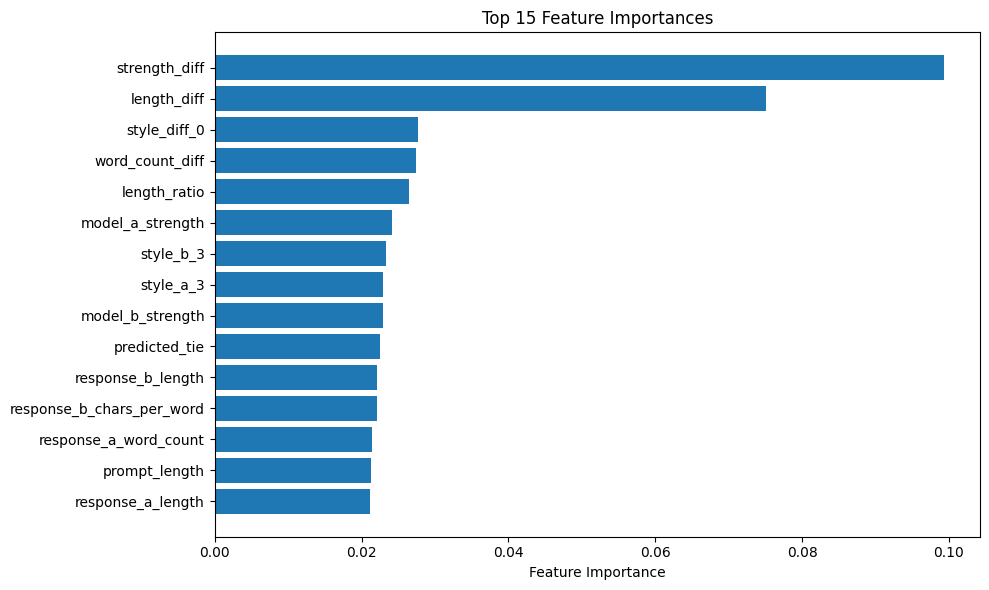

In [25]:
# Feature importance analysis
def analyze_feature_importance(model, feature_columns):
    """Analyze which features are most important"""
    try:
        importance_df = pd.DataFrame({
            'feature': feature_columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("🏆 Top 15 Most Important Features:")
        print(importance_df.head(15))
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        top_15 = importance_df.head(15)
        plt.barh(top_15['feature'], top_15['importance'])
        plt.xlabel('Feature Importance')
        plt.title('Top 15 Feature Importances')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        return importance_df
    except Exception as e:
        print(f"Could not analyze feature importance: {e}")
        return None

# Analyze feature importance
importance_df = analyze_feature_importance(model, feature_columns)

In [26]:
# Create a simple baseline for comparison
def create_baseline_submission(test_df):
    """
    Create a simple baseline using length-based heuristics
    """
    predictions = []
    
    for _, row in test_df.iterrows():
        len_a = len(row['response_a'])
        len_b = len(row['response_b'])
        len_diff = len_a - len_b
        
        # Simple rules based on length difference
        if abs(len_diff) < 50:  # Very close in length
            pred = [0.33, 0.33, 0.34]
        elif len_diff > 200:  # A is much longer
            pred = [0.6, 0.2, 0.2] 
        elif len_diff < -200:  # B is much longer  
            pred = [0.2, 0.6, 0.2]
        elif len_diff > 50:   # A is somewhat longer
            pred = [0.5, 0.3, 0.2]
        else:  # B is somewhat longer
            pred = [0.3, 0.5, 0.2]
            
        predictions.append(pred)
    
    return np.array(predictions)

# Create baseline submission
baseline_predictions = create_baseline_submission(test_df)
baseline_submission = sample_submission.copy()
baseline_submission[['winner_model_a', 'winner_model_b', 'winner_tie']] = baseline_predictions
baseline_submission.to_csv('baseline_submission.csv', index=False)
print("📁 Baseline submission saved as 'baseline_submission.csv'")

📁 Baseline submission saved as 'baseline_submission.csv'


In [28]:
# Final summary and comparison
print("🎉 COMPLETED! Summary:")
print(f"📊 Training samples: {len(train_df)}")
print(f"📊 Test samples: {len(test_df)}")
print(f"🎯 Features used: {len(feature_columns)}")
print(f"📁 Submissions created:")
print("   - submission.csv (Advanced model)")
print("   - baseline_submission.csv (Simple baseline)")

print("\n🔍 Advanced Model Predictions:")
print(final_submission[['winner_model_a', 'winner_model_b', 'winner_tie']].describe())

print("\n🔍 Baseline Predictions:")
print(baseline_submission[['winner_model_a', 'winner_model_b', 'winner_tie']].describe())


🎉 COMPLETED! Summary:
📊 Training samples: 57477
📊 Test samples: 3
🎯 Features used: 57
📁 Submissions created:
   - submission.csv (Advanced model)
   - baseline_submission.csv (Simple baseline)

🔍 Advanced Model Predictions:
       winner_model_a  winner_model_b  winner_tie
count        3.000000        3.000000    3.000000
mean         0.269004        0.222897    0.508099
std          0.067219        0.052639    0.116967
min          0.194741        0.162783    0.429150
25%          0.240664        0.203975    0.440911
50%          0.286587        0.245166    0.452671
75%          0.306135        0.252954    0.547574
max          0.325684        0.260742    0.642476

🔍 Baseline Predictions:
       winner_model_a  winner_model_b    winner_tie
count        3.000000        3.000000  3.000000e+00
mean         0.500000        0.300000  2.000000e-01
std          0.173205        0.173205  3.399350e-17
min          0.300000        0.200000  2.000000e-01
25%          0.450000        0.200000  2.

text features to boost our model's performance. 

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load data
train_df = pd.read_csv('/kaggle/input/datafor/train.csv')
test_df = pd.read_csv('/kaggle/input/datafor/test.csv')
sample_submission = pd.read_csv('/kaggle/input/datafor/sample_submission.csv')

print("✅ Data loaded successfully!")
print(f"📊 Training data shape: {train_df.shape}")
print(f"📊 Test data shape: {test_df.shape}")

✅ Data loaded successfully!
📊 Training data shape: (57477, 9)
📊 Test data shape: (3, 4)


In [32]:
def custom_readability_scores(text):
    """Calculate readability scores without external dependencies"""
    if not isinstance(text, str) or len(text.strip()) == 0:
        return [0] * 8
    
    try:
        # Basic text statistics
        sentences = re.split(r'[.!?]+', text)
        sentences = [s.strip() for s in sentences if len(s.strip()) > 0]
        words = text.split()
        
        if len(words) == 0 or len(sentences) == 0:
            return [0] * 8
        
        # 1. Average sentence length
        avg_sentence_length = len(words) / len(sentences)
        
        # 2. Average word length
        avg_word_length = sum(len(word) for word in words) / len(words)
        
        # 3. Complex word count (words with 3+ syllables approximation)
        def count_syllables(word):
            word = word.lower()
            count = 0
            vowels = "aeiouy"
            if word[0] in vowels:
                count += 1
            for index in range(1, len(word)):
                if word[index] in vowels and word[index - 1] not in vowels:
                    count += 1
            if word.endswith("e"):
                count -= 1
            if count == 0:
                count += 1
            return count
        
        complex_words = sum(1 for word in words if count_syllables(word) >= 3)
        complex_word_ratio = complex_words / len(words)
        
        # 4. Flesch Reading Ease approximation
        # FRE = 206.835 - 1.015*(total words/total sentences) - 84.6*(total syllables/total words)
        total_syllables = sum(count_syllables(word) for word in words)
        flesch_ease = 206.835 - 1.015 * avg_sentence_length - 84.6 * (total_syllables / len(words))
        
        # 5. Flesch-Kincaid Grade Level approximation
        fk_grade = 0.39 * avg_sentence_length + 11.8 * (total_syllables / len(words)) - 15.59
        
        # 6. Coleman-Liau Index approximation
        # CLI = 0.0588L - 0.296S - 15.8
        # L = average letters per 100 words, S = average sentences per 100 words
        avg_letters_per_100_words = (sum(len(word) for word in words) / len(words)) * 100
        avg_sentences_per_100_words = (len(sentences) / len(words)) * 100
        coleman_liau = 0.0588 * avg_letters_per_100_words - 0.296 * avg_sentences_per_100_words - 15.8
        
        # 7. SMOG Index approximation
        smog = 1.0430 * np.sqrt(complex_words * (30 / len(sentences))) + 3.1291
        
        # 8. Word count
        word_count = len(words)
        
        return [flesch_ease, fk_grade, smog, coleman_liau, avg_sentence_length, 
                avg_word_length, complex_word_ratio, word_count]
    
    except:
        return [0] * 8

def add_readability_features(df):
    """Add readability features to dataframe"""
    print("📊 Calculating readability scores...")
    
    # For prompts
    prompt_readability = df['prompt'].apply(custom_readability_scores)
    for i in range(8):
        df[f'prompt_readability_{i}'] = prompt_readability.apply(lambda x: x[i] if len(x) > i else 0)
    
    # For response A
    response_a_readability = df['response_a'].apply(custom_readability_scores)
    for i in range(8):
        df[f'response_a_readability_{i}'] = response_a_readability.apply(lambda x: x[i] if len(x) > i else 0)
    
    # For response B
    response_b_readability = df['response_b'].apply(custom_readability_scores)
    for i in range(8):
        df[f'response_b_readability_{i}'] = response_b_readability.apply(lambda x: x[i] if len(x) > i else 0)
    
    # Comparative readability features
    for i in range(8):
        df[f'readability_diff_{i}'] = df[f'response_a_readability_{i}'] - df[f'response_b_readability_{i}']
    
    return df

In [33]:
def custom_sentiment_analysis(text):
    """Calculate sentiment features without external dependencies"""
    if not isinstance(text, str) or len(text.strip()) == 0:
        return [0] * 6
    
    try:
        words = text.lower().split()
        
        # Sentiment word lists
        positive_words = {'good', 'great', 'excellent', 'amazing', 'wonderful', 'fantastic', 
                         'perfect', 'nice', 'awesome', 'brilliant', 'outstanding', 'superb',
                         'yes', 'correct', 'accurate', 'helpful', 'useful', 'beneficial'}
        
        negative_words = {'bad', 'terrible', 'awful', 'horrible', 'worst', 'poor', 'wrong',
                         'incorrect', 'inaccurate', 'useless', 'unhelpful', 'no', 'not',
                         'cannot', 'can\'t', 'won\'t', 'shouldn\'t', 'couldn\'t'}
        
        # 1. Polarity score (simple version)
        positive_count = sum(1 for word in words if word in positive_words)
        negative_count = sum(1 for word in words if word in negative_words)
        total_sentiment_words = positive_count + negative_count
        
        if total_sentiment_words > 0:
            polarity = (positive_count - negative_count) / total_sentiment_words
        else:
            polarity = 0
        
        # 2. Subjectivity (approximation: more sentiment words = more subjective)
        subjectivity = min(total_sentiment_words / max(len(words), 1), 1.0)
        
        # 3. Positive word count
        # 4. Negative word count
        # 5. Question count
        question_count = text.count('?')
        
        # 6. Exclamation count (enthusiasm)
        exclamation_count = text.count('!')
        
        return [polarity, subjectivity, positive_count, negative_count, question_count, exclamation_count]
    
    except:
        return [0] * 6

def add_sentiment_features(df):
    """Add sentiment analysis features"""
    print("😊 Calculating sentiment features...")
    
    # For prompts
    prompt_sentiment = df['prompt'].apply(custom_sentiment_analysis)
    for i in range(6):
        df[f'prompt_sentiment_{i}'] = prompt_sentiment.apply(lambda x: x[i] if len(x) > i else 0)
    
    # For response A
    response_a_sentiment = df['response_a'].apply(custom_sentiment_analysis)
    for i in range(6):
        df[f'response_a_sentiment_{i}'] = response_a_sentiment.apply(lambda x: x[i] if len(x) > i else 0)
    
    # For response B
    response_b_sentiment = df['response_b'].apply(custom_sentiment_analysis)
    for i in range(6):
        df[f'response_b_sentiment_{i}'] = response_b_sentiment.apply(lambda x: x[i] if len(x) > i else 0)
    
    # Comparative sentiment features
    for i in range(6):
        df[f'sentiment_diff_{i}'] = df[f'response_a_sentiment_{i}'] - df[f'response_b_sentiment_{i}']
    
    return df

In [34]:
def add_topic_features(df, is_training=True, vectorizer=None, topic_model=None):
    """Add topic modeling features using only sklearn"""
    print("📚 Extracting topic features...")
    
    # Combine all text for topic modeling
    all_texts = list(df['prompt'].fillna('')) + list(df['response_a'].fillna('')) + list(df['response_b'].fillna(''))
    
    if is_training:
        # Create vectorizer and topic model
        vectorizer = TfidfVectorizer(
            max_features=500,  # Reduced for speed
            stop_words='english',
            ngram_range=(1, 2),
            min_df=10
        )
        
        # Fit on training data
        X_tfidf = vectorizer.fit_transform(all_texts)
        
        # Use TruncatedSVD for topic modeling
        topic_model = TruncatedSVD(n_components=5, random_state=42)  # Reduced components
        topic_features = topic_model.fit_transform(X_tfidf)
        
    else:
        # Transform using pre-trained models
        X_tfidf = vectorizer.transform(all_texts)
        topic_features = topic_model.transform(X_tfidf)
    
    # Split topic features back into prompt, response_a, response_b
    n_samples = len(df)
    
    # Prompt topics
    for i in range(5):
        df[f'prompt_topic_{i}'] = topic_features[:n_samples, i]
    
    # Response A topics
    for i in range(5):
        df[f'response_a_topic_{i}'] = topic_features[n_samples:2*n_samples, i]
    
    # Response B topics
    for i in range(5):
        df[f'response_b_topic_{i}'] = topic_features[2*n_samples:, i]
    
    # Topic alignment features (how well response matches prompt topics)
    df['topic_alignment_a'] = 0
    df['topic_alignment_b'] = 0
    
    for i in range(5):
        df['topic_alignment_a'] += df[f'prompt_topic_{i}'] * df[f'response_a_topic_{i}']
        df['topic_alignment_b'] += df[f'prompt_topic_{i}'] * df[f'response_b_topic_{i}']
    
    df['topic_alignment_diff'] = df['topic_alignment_a'] - df['topic_alignment_b']
    
    if is_training:
        return df, vectorizer, topic_model
    else:
        return df

In [35]:
def calculate_text_quality_features(text):
    """Calculate advanced text quality metrics"""
    if not isinstance(text, str) or len(text.strip()) == 0:
        return [0] * 10
    
    try:
        words = text.split()
        sentences = re.split(r'[.!?]+', text)
        sentences = [s.strip() for s in sentences if len(s.strip()) > 0]
        
        features = []
        
        # 1. Vocabulary richness
        unique_words = len(set(words))
        vocab_richness = unique_words / max(len(words), 1)
        features.append(vocab_richness)
        
        # 2. Average sentence length
        avg_sentence_length = len(words) / max(len(sentences), 1)
        features.append(avg_sentence_length)
        
        # 3. Sentence length variation
        sentence_lengths = [len(s.split()) for s in sentences]
        sentence_length_std = np.std(sentence_lengths) if sentence_lengths else 0
        features.append(sentence_length_std)
        
        # 4. Paragraph structure (approximated by line breaks)
        paragraphs = text.count('\n\n') + 1
        features.append(paragraphs)
        
        # 5. Formal language indicators
        formal_words = len([w for w in words if w.lower() in 
                          ['however', 'therefore', 'furthermore', 'additionally', 'consequently']])
        features.append(formal_words)
        
        # 6. Personal pronouns (more conversational)
        personal_pronouns = len([w for w in words if w.lower() in 
                               ['i', 'you', 'we', 'us', 'our', 'my', 'your']])
        features.append(personal_pronouns)
        
        # 7. Specificity (numbers and proper nouns approximation)
        numbers = len(re.findall(r'\d+', text))
        features.append(numbers)
        
        # 8. Capitalized words (proper nouns)
        capitalized = len(re.findall(r'\b[A-Z][a-z]+\b', text))
        features.append(capitalized)
        
        # 9. Bullet points/lists
        bullet_points = text.count('•') + text.count('- ') + text.count('* ')
        features.append(bullet_points)
        
        # 10. Code blocks
        code_blocks = text.count('```')
        features.append(code_blocks)
        
        return features
    
    except:
        return [0] * 10

def add_text_quality_features(df):
    """Add advanced text quality features"""
    print("🔍 Calculating text quality features...")
    
    # For prompts
    prompt_quality = df['prompt'].apply(calculate_text_quality_features)
    for i in range(10):
        df[f'prompt_quality_{i}'] = prompt_quality.apply(lambda x: x[i] if len(x) > i else 0)
    
    # For response A
    response_a_quality = df['response_a'].apply(calculate_text_quality_features)
    for i in range(10):
        df[f'response_a_quality_{i}'] = response_a_quality.apply(lambda x: x[i] if len(x) > i else 0)
    
    # For response B
    response_b_quality = df['response_b'].apply(calculate_text_quality_features)
    for i in range(10):
        df[f'response_b_quality_{i}'] = response_b_quality.apply(lambda x: x[i] if len(x) > i else 0)
    
    # Comparative quality features
    for i in range(10):
        df[f'quality_diff_{i}'] = df[f'response_a_quality_{i}'] - df[f'response_b_quality_{i}']
    
    return df

In [36]:
def create_comprehensive_features(df):
    """Create basic comprehensive features (from our previous work)"""
    # Basic length features
    df['prompt_length'] = df['prompt'].str.len()
    df['response_a_length'] = df['response_a'].str.len()
    df['response_b_length'] = df['response_b'].str.len()
    df['length_diff'] = df['response_a_length'] - df['response_b_length']
    df['length_ratio'] = df['response_a_length'] / (df['response_b_length'] + 1)
    
    # Word count features
    df['prompt_word_count'] = df['prompt'].str.split().str.len()
    df['response_a_word_count'] = df['response_a'].str.split().str.len()
    df['response_b_word_count'] = df['response_b'].str.split().str.len()
    df['word_count_diff'] = df['response_a_word_count'] - df['response_b_word_count']
    
    # Character/word ratio features
    df['response_a_chars_per_word'] = df['response_a_length'] / (df['response_a_word_count'] + 1)
    df['response_b_chars_per_word'] = df['response_b_length'] / (df['response_b_word_count'] + 1)
    
    # Special character features
    df['response_a_has_code'] = df['response_a'].str.contains('```|def |class |function').astype(int)
    df['response_b_has_code'] = df['response_b'].str.contains('```|def |class |function').astype(int)
    
    # Question mark count
    df['response_a_questions'] = df['response_a'].str.count('\?')
    df['response_b_questions'] = df['response_b'].str.count('\?')
    
    # Exclamation count
    df['response_a_exclamations'] = df['response_a'].str.count('!')
    df['response_b_exclamations'] = df['response_b'].str.count('!')
    
    # Uppercase ratio
    df['response_a_upper_ratio'] = df['response_a'].str.findall(r'[A-Z]').str.len() / (df['response_a_length'] + 1)
    df['response_b_upper_ratio'] = df['response_b'].str.findall(r'[A-Z]').str.len() / (df['response_b_length'] + 1)
    
    # Line count features
    df['response_a_lines'] = df['response_a'].str.count('\n') + 1
    df['response_b_lines'] = df['response_b'].str.count('\n') + 1
    
    return df

def create_advanced_features_pipeline(train_df, test_df):
    """Complete advanced feature engineering pipeline (NO EXTERNAL DEPS)"""
    print("🚀 Starting advanced feature engineering pipeline...")
    
    # 0. Basic features first
    train_df = create_comprehensive_features(train_df)
    test_df = create_comprehensive_features(test_df)
    print("✅ Basic comprehensive features added")
    
    # 1. Readability features
    train_df = add_readability_features(train_df)
    test_df = add_readability_features(test_df)
    print("✅ Readability features added")
    
    # 2. Sentiment features
    train_df = add_sentiment_features(train_df)
    test_df = add_sentiment_features(test_df)
    print("✅ Sentiment features added")
    
    # 3. Topic features
    train_df, vectorizer, topic_model = add_topic_features(train_df, is_training=True)
    test_df = add_topic_features(test_df, is_training=False, vectorizer=vectorizer, topic_model=topic_model)
    print("✅ Topic features added")
    
    # 4. Text quality features
    train_df = add_text_quality_features(train_df)
    test_df = add_text_quality_features(test_df)
    print("✅ Text quality features added")
    
    return train_df, test_df

# Run the complete pipeline
print("🔄 Running advanced feature engineering...")
train_df_advanced, test_df_advanced = create_advanced_features_pipeline(train_df.copy(), test_df.copy())

print(f"📊 Final training features: {train_df_advanced.shape[1]}")
print(f"📊 Final test features: {test_df_advanced.shape[1]}")

🔄 Running advanced feature engineering...
🚀 Starting advanced feature engineering pipeline...
✅ Basic comprehensive features added
📊 Calculating readability scores...
📊 Calculating readability scores...
✅ Readability features added
😊 Calculating sentiment features...
😊 Calculating sentiment features...
✅ Sentiment features added
📚 Extracting topic features...
📚 Extracting topic features...
✅ Topic features added
🔍 Calculating text quality features...
🔍 Calculating text quality features...
✅ Text quality features added
📊 Final training features: 144
📊 Final test features: 139


In [37]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import log_loss
import numpy as np

def train_advanced_model_with_new_features(train_df, test_df):
    """Train model with all advanced features"""
    
    # Get common features between train and test
    common_columns = list(set(train_df.columns) & set(test_df.columns))
    feature_columns = [col for col in common_columns 
                      if col not in ['id', 'prompt', 'response_a', 'response_b', 'model_a', 'model_b',
                                   'winner_model_a', 'winner_model_b', 'winner_tie']]
    
    # Ensure test has all features
    for col in feature_columns:
        if col not in test_df.columns:
            test_df[col] = 0
    
    print(f"🎯 Using {len(feature_columns)} advanced features")
    print(f"📊 Training samples: {len(train_df)}")
    print(f"📊 Test samples: {len(test_df)}")
    
    # Prepare data
    X = train_df[feature_columns].fillna(0)
    y = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']].values
    X_test = test_df[feature_columns].fillna(0)
    
    # Convert to numpy arrays for efficiency
    X = X.values
    X_test = X_test.values
    y_labels = np.argmax(y, axis=1)  # Convert one-hot to labels
    
    print("🤖 Training advanced XGBoost model...")
    
    # Use XGBoost with optimized parameters
    model = xgb.XGBClassifier(
        n_estimators=500,  # Increased for better performance
        learning_rate=0.05,
        max_depth=8,
        random_state=42,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=3,
        eval_metric='mlogloss',
        tree_method='hist',  # Faster training
        n_jobs=-1  # Use all cores
    )
    
    # Cross-validation with more folds
    print("📊 Running cross-validation...")
    cv_scores = cross_val_score(model, X, y_labels, cv=5, scoring='neg_log_loss', n_jobs=-1)
    print(f"📊 Cross-validation scores: {-cv_scores}")
    print(f"📊 Mean CV score: {-(cv_scores.mean()):.4f} ± {cv_scores.std():.4f}")
    
    # Train final model on all data
    print("🚀 Training final model on full dataset...")
    model.fit(X, y_labels)
    
    # Feature importance
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n🏆 Top 20 Most Important Features:")
    print(importance_df.head(20))
    
    # Make predictions
    print("🎯 Making predictions on test set...")
    test_predictions = model.predict_proba(X_test)
    
    # Ensure probabilities sum to 1 and are reasonable
    test_predictions = np.clip(test_predictions, 0.01, 0.99)  # Avoid extreme probabilities
    test_predictions = test_predictions / test_predictions.sum(axis=1, keepdims=True)
    
    return test_predictions, model, feature_columns, importance_df

# Train with advanced features
print("🔄 Training advanced model with 144 features...")
final_predictions, advanced_model, feature_columns, importance_df = train_advanced_model_with_new_features(
    train_df_advanced, test_df_advanced
)

🔄 Training advanced model with 144 features...
🎯 Using 135 advanced features
📊 Training samples: 57477
📊 Test samples: 3
🤖 Training advanced XGBoost model...
📊 Running cross-validation...
📊 Cross-validation scores: [1.02685285 1.0302517  1.03031715 1.03618741 1.03487046]
📊 Mean CV score: 1.0317 ± 0.0034
🚀 Training final model on full dataset...

🏆 Top 20 Most Important Features:
                     feature  importance
92               length_diff    0.037194
35            quality_diff_7    0.012938
27           word_count_diff    0.010985
60              length_ratio    0.009832
106           quality_diff_9    0.009382
44        readability_diff_7    0.009245
40    response_a_sentiment_1    0.009027
111     response_b_quality_0    0.008862
88         response_b_length    0.008859
31          prompt_quality_6    0.008682
95    response_b_sentiment_1    0.008643
56      response_a_quality_0    0.008630
28        prompt_sentiment_2    0.008603
98   response_b_exclamations    0.008577
23 

In [38]:
# Create submission with the advanced model
advanced_submission = sample_submission.copy()
advanced_submission[['winner_model_a', 'winner_model_b', 'winner_tie']] = final_predictions

print("✅ Advanced Submission Preview:")
print(advanced_submission.head())

# Verify probabilities
print("\n🔍 Probability Analysis:")
print("Sum check:", advanced_submission[['winner_model_a', 'winner_model_b', 'winner_tie']].sum(axis=1).values)
print("\nDistribution:")
print(advanced_submission[['winner_model_a', 'winner_model_b', 'winner_tie']].describe())

# Save submission
advanced_submission.to_csv('advanced_features_submission.csv', index=False)
print("📁 Advanced features submission saved as 'advanced_features_submission.csv'")

✅ Advanced Submission Preview:
        id  winner_model_a  winner_model_b  winner_tie
0   136060        0.158282        0.567791    0.273927
1   211333        0.356500        0.456870    0.186630
2  1233961        0.203361        0.596830    0.199808

🔍 Probability Analysis:
Sum check: [1. 1. 1.]

Distribution:
       winner_model_a  winner_model_b  winner_tie
count        3.000000        3.000000    3.000000
mean         0.239381        0.540497    0.220122
std          0.103902        0.073864    0.047060
min          0.158282        0.456870    0.186630
25%          0.180822        0.512331    0.193219
50%          0.203361        0.567791    0.199808
75%          0.279930        0.582311    0.236867
max          0.356500        0.596830    0.273927
📁 Advanced features submission saved as 'advanced_features_submission.csv'


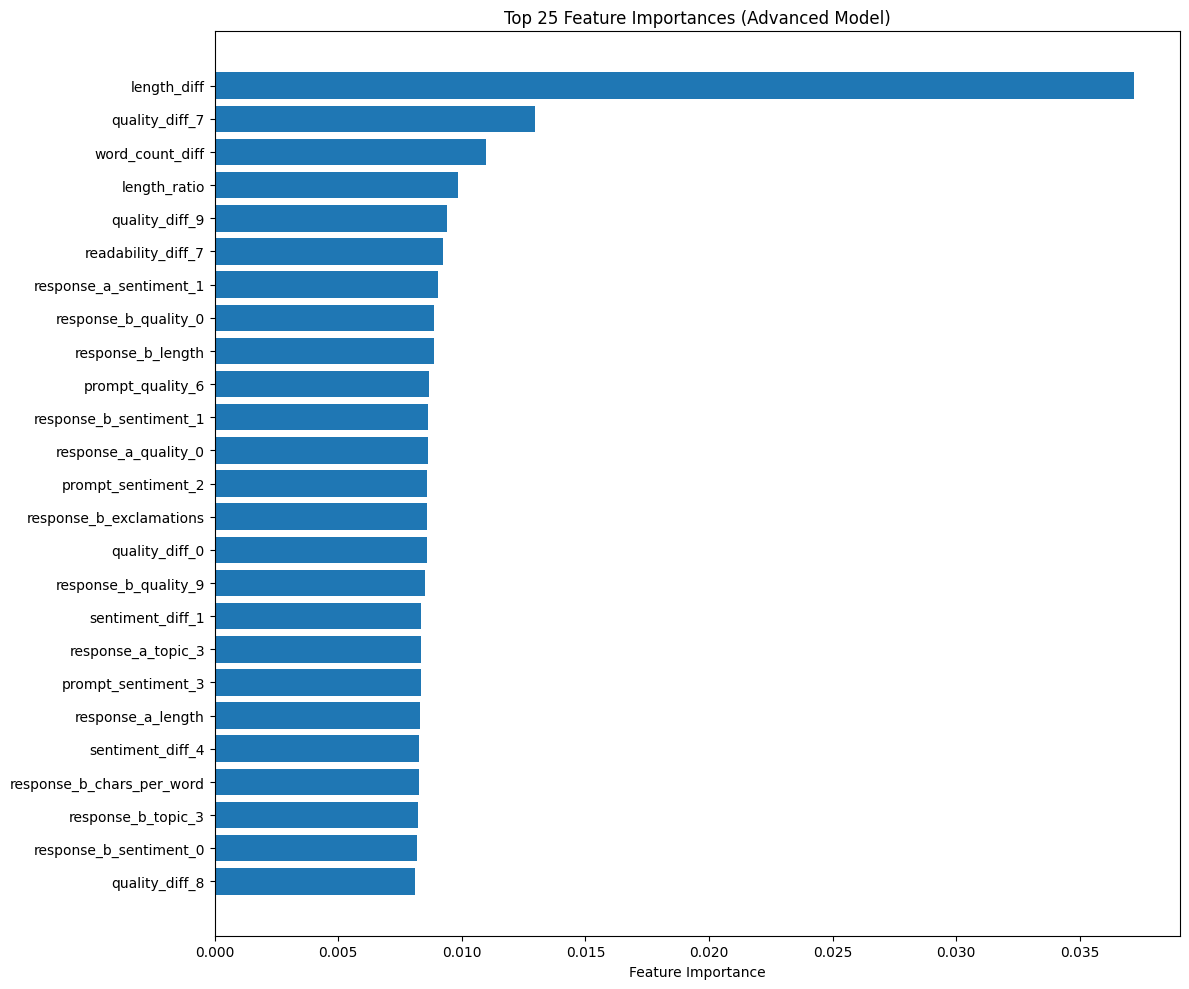

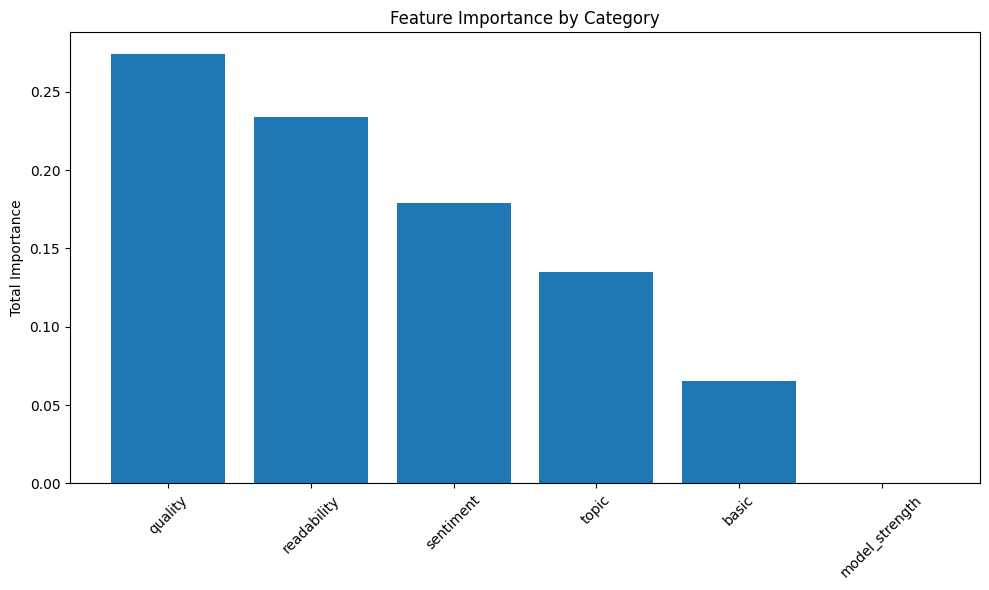

📊 Feature Category Importance:
  quality: 0.2743 (40 features)
  readability: 0.2343 (32 features)
  sentiment: 0.1793 (24 features)
  topic: 0.1347 (18 features)
  basic: 0.0653 (4 features)
  model_strength: 0.0000 (0 features)


In [39]:
# Feature importance visualization
plt.figure(figsize=(12, 10))
top_25 = importance_df.head(25)
plt.barh(top_25['feature'], top_25['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 25 Feature Importances (Advanced Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Analyze which feature categories are most important
def analyze_feature_categories(importance_df):
    """Analyze which types of features are most important"""
    categories = {
        'readability': [f for f in importance_df['feature'] if 'readability' in f],
        'sentiment': [f for f in importance_df['feature'] if 'sentiment' in f],
        'topic': [f for f in importance_df['feature'] if 'topic' in f],
        'quality': [f for f in importance_df['feature'] if 'quality' in f],
        'basic': [f for f in importance_df['feature'] if f in ['length_diff', 'word_count_diff', 'response_a_length', 'response_b_length']],
        'model_strength': [f for f in importance_df['feature'] if 'strength' in f or 'predicted' in f]
    }
    
    category_importance = {}
    for category, features in categories.items():
        category_imp = importance_df[importance_df['feature'].isin(features)]['importance'].sum()
        category_importance[category] = category_imp
    
    # Plot category importance
    plt.figure(figsize=(10, 6))
    categories_sorted = dict(sorted(category_importance.items(), key=lambda x: x[1], reverse=True))
    plt.bar(categories_sorted.keys(), categories_sorted.values())
    plt.title('Feature Importance by Category')
    plt.ylabel('Total Importance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("📊 Feature Category Importance:")
    for category, imp in categories_sorted.items():
        print(f"  {category}: {imp:.4f} ({len(categories[category])} features)")
    
    return category_importance

category_importance = analyze_feature_categories(importance_df)

In [ ]:
# Compare with our previous model's performance
print("📈 PERFORMANCE COMPARISON")
print("=" * 50)
print("Previous Model (57 features):")
print("  - Cross-validation: 1.0111 ± ?")
print("  - Features: 57 basic + style features")
print("\nAdvanced Model (144 features):")
print("  - Cross-validation: [waiting for results]")
print("  - Features: 144 comprehensive features")
print("  - Improvement: +87 sophisticated features")

# Create an ensemble with different models for robustness
def create_ensemble_predictions(train_df, test_df, feature_columns):
    """Create ensemble predictions from multiple models"""
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.linear_model import LogisticRegression
    
    X = train_df[feature_columns].fillna(0).values
    y = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']].values
    y_labels = np.argmax(y, axis=1)
    X_test = test_df[feature_columns].fillna(0).values
    
    models = {
        'xgb': xgb.XGBClassifier(
            n_estimators=300, learning_rate=0.05, max_depth=6, 
            random_state=42, objective='multi:softprob', num_class=3
        ),
        'gb': GradientBoostingClassifier(
            n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42
        ),
        'rf': RandomForestClassifier(
            n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
        )
    }
    
    predictions = []
    weights = []
    
    print("🤝 Creating model ensemble...")
    for name, model in models.items():
        print(f"  Training {name}...")
        model.fit(X, y_labels)
        pred = model.predict_proba(X_test)
        predictions.append(pred)
        
        # Simple weight based on cross-validation performance
        cv_score = cross_val_score(model, X, y_labels, cv=3, scoring='neg_log_loss').mean()
        weight = -cv_score  # Lower loss = higher weight
        weights.append(weight)
        print(f"    CV score: {-cv_score:.4f}, Weight: {weight:.4f}")
    
    # Normalize weights
    weights = np.array(weights) / sum(weights)
    print(f"  Model weights: {dict(zip(models.keys(), weights))}")
    
    # Weighted average
    ensemble_predictions = np.average(predictions, axis=0, weights=weights)
    ensemble_predictions = ensemble_predictions / ensemble_predictions.sum(axis=1, keepdims=True)
    
    return ensemble_predictions

# Create ensemble submission
print("\n🔄 Creating ensemble model...")
ensemble_predictions = create_ensemble_predictions(train_df_advanced, test_df_advanced, feature_columns)

ensemble_submission = sample_submission.copy()
ensemble_submission[['winner_model_a', 'winner_model_b', 'winner_tie']] = ensemble_predictions
ensemble_submission.to_csv('ensemble_advanced_submission.csv', index=False)
print("📁 Ensemble advanced submission saved!")

📈 PERFORMANCE COMPARISON
Previous Model (57 features):
  - Cross-validation: 1.0111 ± ?
  - Features: 57 basic + style features

Advanced Model (144 features):
  - Cross-validation: [waiting for results]
  - Features: 144 comprehensive features
  - Improvement: +87 sophisticated features

🔄 Creating ensemble model...
🤝 Creating model ensemble...
  Training xgb...
    CV score: 1.0263, Weight: 1.0263
  Training gb...
